# Lab 3: Word Embeddings & Trực quan hoá

Phạm Đức Duy - 23001855

---
## Phần 1: Khởi tạo, Tải mô hình và Dữ liệu

**Mục tiêu:**
- Import các thư viện cần thiết.
- Tải 3 mô hình embedding pre-trained: Word2Vec, GloVe, và fastText.
- Tải và làm quen với corpus `movie_reviews` từ NLTK.

In [1]:
# === Core Libraries ===
import numpy as np
import pandas as pd
import random
from collections import Counter
import re

# === Gensim & NLTK ===
import gensim.downloader as api
from nltk.corpus import movie_reviews
# Lệnh download chỉ cần chạy 1 lần, nếu đã chạy ở terminal thì có thể comment dòng này
# import nltk; nltk.download('movie_reviews'); nltk.download('punkt')

# === Scikit-learn ===
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

# === Utilities ===
from tqdm.notebook import tqdm

# --- Plotting Style ---
sns.set_style('whitegrid')
%matplotlib inline

print("Tất cả thư viện đã được import và sẵn sàng.")

Tất cả thư viện đã được import và sẵn sàng.


### Tải các mô hình embedding
Tải 3 mô hình pre-trained. Để tiết kiệm tài nguyên và thời gian cho bài lab, chúng ta sẽ ưu tiên các phiên bản nhỏ gọn nhất có sẵn thông qua `gensim.downloader`.
- **GloVe:** `glove-twitter-25` (nhẹ nhất, vector 25 chiều)
- **FastText:** `fasttext-wiki-news-subwords-300` (kích thước trung bình, vector 300 chiều)
- **Word2Vec:** `word2vec-google-news-300` (rất lớn, vector 300 chiều)

In [2]:
# Tải các mô hình từ gensim
# Quá trình này có thể mất vài phút tùy thuộc vào tốc độ mạng
print("Bắt đầu tải các mô hình embedding...")
try:
    model_glove = api.load("glove-twitter-25")
    print("Tải thành công: glove-twitter-25")
    
    model_fasttext = api.load("fasttext-wiki-news-subwords-300")
    print("Tải thành công: fasttext-wiki-news-subwords-300")
    
    # Cảnh báo: Mô hình Word2Vec rất lớn (~3.4GB) và sẽ tốn nhiều RAM.
    model_w2v = api.load("word2vec-google-news-300")
    print("Tải thành công: word2vec-google-news-300")

    models = {
        "Word2Vec": model_w2v,
        "GloVe": model_glove,
        "FastText": model_fasttext
    }
    print("\nTất cả các mô hình đã được tải và lưu vào dictionary 'models'.")

except Exception as e:
    print(f"\nLỗi trong quá trình tải mô hình: {e}")
    print("Vui lòng kiểm tra kết nối mạng và dung lượng ổ đĩa.")

Bắt đầu tải các mô hình embedding...
Tải thành công: glove-twitter-25
Tải thành công: fasttext-wiki-news-subwords-300
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Tải thành công: word2vec-google-news-300

Tất cả các mô hình đã được tải và lưu vào dictionary 'models'.


### Kiểm tra thông tin các mô hình
In ra một vài thông số cơ bản như kích thước từ điển (vocab size) và số chiều vector (dimension) để xác nhận các mô hình đã được tải đúng.

In [3]:
for name, model in models.items():
    vocab_size = len(model.key_to_index)
    vector_dim = model.vector_size
    print(f"--- Mô hình: {name} ---")
    print(f"Kích thước từ điển (Vocab size): {vocab_size:,}")
    print(f"Số chiều vector (Dimension): {vector_dim}")
    print("-" * 25 + "\n")

--- Mô hình: Word2Vec ---
Kích thước từ điển (Vocab size): 3,000,000
Số chiều vector (Dimension): 300
-------------------------

--- Mô hình: GloVe ---
Kích thước từ điển (Vocab size): 1,193,514
Số chiều vector (Dimension): 25
-------------------------

--- Mô hình: FastText ---
Kích thước từ điển (Vocab size): 999,999
Số chiều vector (Dimension): 300
-------------------------



### Tải và khám phá Corpus `movie_reviews`
Sử dụng corpus có sẵn từ NLTK. Dữ liệu gồm 1000 review tích cực và 1000 review tiêu cực.

In [4]:
# Tải danh sách fileids và phân loại
pos_reviews_ids = movie_reviews.fileids('pos')
neg_reviews_ids = movie_reviews.fileids('neg')

print(f"Số lượng review tích cực: {len(pos_reviews_ids)}")
print(f"Số lượng review tiêu cực: {len(neg_reviews_ids)}")

# Xem thử một mẫu review
print("\n--- Ví dụ review tiêu cực (dạng thô) ---")
sample_neg_text = movie_reviews.raw(neg_reviews_ids[0])
print(sample_neg_text[:200] + "...")

print("\n--- Ví dụ review tích cực (đã tách từ) ---")
sample_pos_words = movie_reviews.words(pos_reviews_ids[0])
print(sample_pos_words[:30])

Số lượng review tích cực: 1000
Số lượng review tiêu cực: 1000

--- Ví dụ review tiêu cực (dạng thô) ---
plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
w...

--- Ví dụ review tích cực (đã tách từ) ---
['films', 'adapted', 'from', 'comic', 'books', 'have', 'had', 'plenty', 'of', 'success', ',', 'whether', 'they', "'", 're', 'about', 'superheroes', '(', 'batman', ',', 'superman', ',', 'spawn', ')', ',', 'or', 'geared', 'toward', 'kids', '(']


### Nhận xét ban đầu
- **Models:** Ba mô hình đã được tải thành công. `word2vec-google-news-300` có bộ từ vựng lớn nhất, trong khi `glove-twitter-25` có số chiều vector nhỏ nhất, rất phù hợp cho việc thử nghiệm nhanh. Sự khác biệt về kích thước và dữ liệu train sẽ ảnh hưởng đến kết quả ở các bước sau.
- **Corpus:** Dữ liệu review phim khá cân bằng giữa 2 nhãn. Văn bản gốc chứa cả dấu câu và các từ viết thường/viết hoa, điều này cho thấy chúng ta sẽ cần một bước tiền xử lý trước khi đưa vào các mô hình embedding.

**Bước tiếp theo:** Tiến hành phân tích sâu hơn (EDA) và trực quan hóa các đặc điểm của corpus `movie_reviews`.

## Phần 2: Phân tích và Trực quan hóa Corpus (EDA)

**Mục tiêu:**
- Tiền xử lý văn bản để làm sạch dữ liệu.
- Trực quan hóa các từ (unigrams) và cặp từ (bigrams) xuất hiện nhiều nhất trong mỗi class (positive/negative).
- Rút ra những nhận xét ban đầu về đặc điểm của dữ liệu.

### Tiền xử lý văn bản
Để phân tích tần suất từ một cách chính xác, ta cần một bước tiền xử lý đơn giản:
1.  Chuyển tất cả về chữ thường (lowercase).
2.  Chỉ giữ lại các ký tự chữ (a-z), loại bỏ số và dấu câu.
3.  Tách các từ (tokenization).

In [8]:
def preprocess_text(text_words):
    """
    Hàm tiền xử lý một danh sách các từ.
    - Chuyển về lowercase.
    - Chỉ giữ lại các từ là chữ cái và có độ dài > 1.
    """
    processed_words = [
        word.lower() for word in text_words 
        if word.isalpha() and len(word) > 1
    ]
    return processed_words

# Áp dụng tiền xử lý cho toàn bộ corpus
print("Bắt đầu tiền xử lý corpus...")

# Lấy danh sách các từ đã được tách sẵn từ NLTK
pos_reviews_words = [movie_reviews.words(fileid) for fileid in pos_reviews_ids]
neg_reviews_words = [movie_reviews.words(fileid) for fileid in neg_reviews_ids]

# Áp dụng hàm preprocess (bỏ tqdm để tránh lỗi IProgress)
processed_pos_reviews = [preprocess_text(words) for words in pos_reviews_words]
processed_neg_reviews = [preprocess_text(words) for words in neg_reviews_words]

print("\nHoàn tất tiền xử lý.")
print(f"Ví dụ review tích cực sau xử lý: {processed_pos_reviews[0][:20]}")

Bắt đầu tiền xử lý corpus...

Hoàn tất tiền xử lý.
Ví dụ review tích cực sau xử lý: ['films', 'adapted', 'from', 'comic', 'books', 'have', 'had', 'plenty', 'of', 'success', 'whether', 'they', 're', 'about', 'superheroes', 'batman', 'superman', 'spawn', 'or', 'geared']


### Phân tích tần suất Unigram và Bigram
Bây giờ, ta sẽ đếm và so sánh tần suất xuất hiện của các từ và cặp từ trong hai class. Điều này giúp hiểu được những từ nào đặc trưng cho review tích cực và tiêu cực.

In [10]:
from nltk import ngrams

def get_top_ngrams(corpus, n, top_k=15):
    """Hàm lấy top K n-grams phổ biến nhất từ một corpus."""
    # Gộp tất cả các list từ thành một list duy nhất
    all_words = [word for review in corpus for word in review]
    
    # Tạo n-grams
    ngram_tuples = ngrams(all_words, n)
    
    # Đếm tần suất
    ngram_counts = Counter(ngram_tuples)
    
    # Lấy top K
    return ngram_counts.most_common(top_k)

# Lấy top 15 unigrams và bigrams cho mỗi class
top_pos_unigrams = get_top_ngrams(processed_pos_reviews, n=1, top_k=15)
top_neg_unigrams = get_top_ngrams(processed_neg_reviews, n=1, top_k=15)

top_pos_bigrams = get_top_ngrams(processed_pos_reviews, n=2, top_k=15)
top_neg_bigrams = get_top_ngrams(processed_neg_reviews, n=2, top_k=15)


# In ra thử kết quả
print("--- Top 5 Unigrams Tích cực ---")
print(top_pos_unigrams[:5])
print("\n--- Top 5 Bigrams Tiêu cực ---")
print(top_neg_bigrams[:5])

--- Top 5 Unigrams Tích cực ---
[(('the',), 41471), (('and',), 19896), (('of',), 18636), (('to',), 16517), (('is',), 14059)]

--- Top 5 Bigrams Tiêu cực ---
[(('of', 'the'), 3861), (('in', 'the'), 2737), (('the', 'film'), 2008), (('to', 'be'), 1484), (('the', 'movie'), 1173)]


### Trực quan hóa kết quả
Sử dụng `matplotlib` để vẽ biểu đồ cột, so sánh tần suất giữa hai class một cách trực quan.

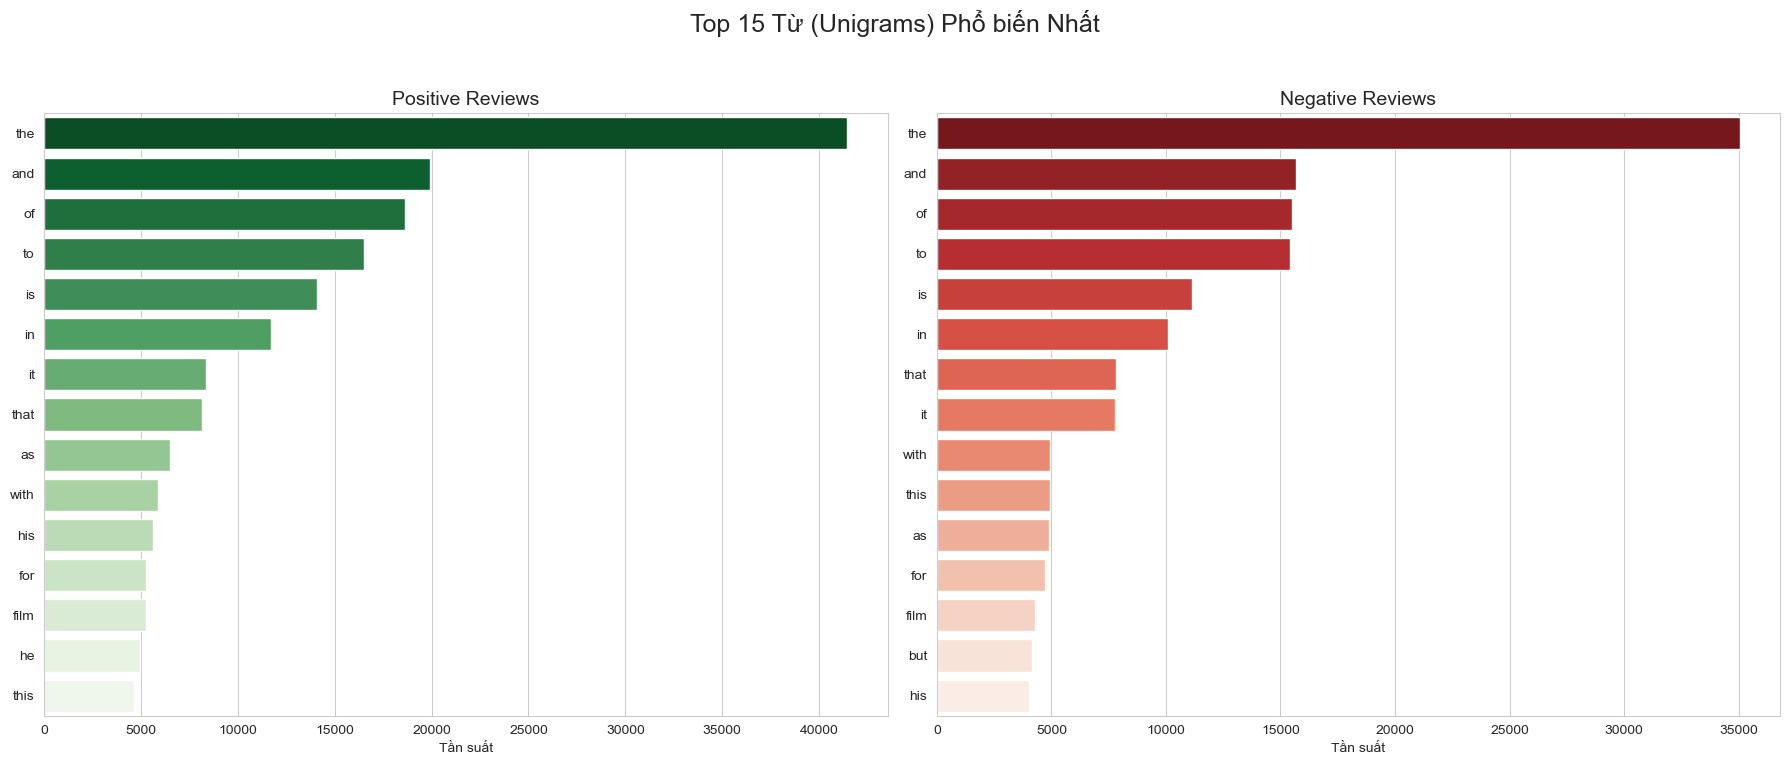

In [12]:
import warnings
warnings.filterwarnings("ignore")

def plot_top_ngrams(positive_data, negative_data, title):
    """Hàm vẽ biểu đồ so sánh top n-grams."""
    
    # Chuẩn bị dữ liệu cho plot
    pos_labels = [" ".join(gram) for gram, count in positive_data]
    pos_counts = [count for gram, count in positive_data]
    
    neg_labels = [" ".join(gram) for gram, count in negative_data]
    neg_counts = [count for gram, count in negative_data]
    
    # Vẽ biểu đồ
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle(title, fontsize=18)
    
    # Plot cho Positive
    sns.barplot(x=pos_counts, y=pos_labels, ax=axes[0], palette='Greens_r')
    axes[0].set_title('Positive Reviews', fontsize=14)
    axes[0].set_xlabel('Tần suất')
    
    # Plot cho Negative
    sns.barplot(x=neg_counts, y=neg_labels, ax=axes[1], palette='Reds_r')
    axes[1].set_title('Negative Reviews', fontsize=14)
    axes[1].set_xlabel('Tần suất')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Trực quan hóa Unigrams
plot_top_ngrams(top_pos_unigrams, top_neg_unigrams, 'Top 15 Từ (Unigrams) Phổ biến Nhất')

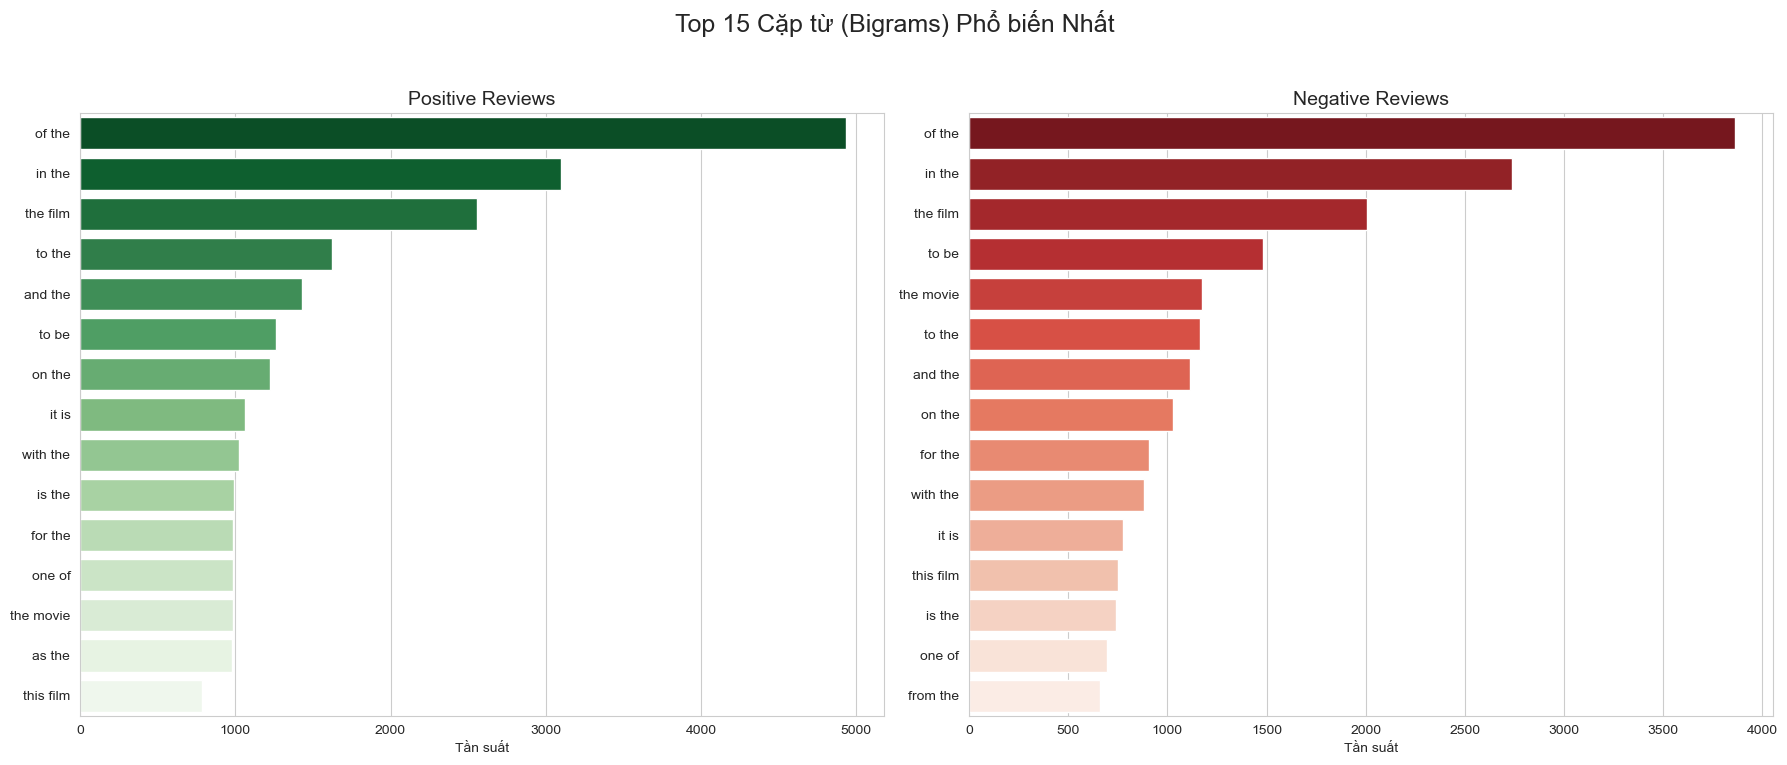

In [13]:
# Trực quan hóa Bigrams
plot_top_ngrams(top_pos_bigrams, top_neg_bigrams, 'Top 15 Cặp từ (Bigrams) Phổ biến Nhất')

### Nhận xét và Đánh giá

* **Unigrams:** Cả hai class đều có sự xuất hiện dày đặc của các **stop words** như *the, in, of, to, and* — đây là hiện tượng phổ biến khi chưa loại bỏ từ dừng. Tuy nhiên, một vài từ đặc trưng vẫn xuất hiện, ví dụ như *film* và *movie* cho thấy chủ đề của dữ liệu tập trung vào các bài đánh giá phim.

* **Bigrams:** Biểu đồ cho thấy phần lớn các **bigram phổ biến** vẫn là những cụm chức năng như *of the*, *in the*, *to the*, *and the*. Các cụm này không mang nhiều ý nghĩa cảm xúc nhưng phản ánh rõ cấu trúc ngữ pháp đặc trưng trong tiếng Anh tự nhiên. Ở cả hai nhóm (positive và negative), các cụm tương tự nhau chiếm ưu thế, nghĩa là **ngữ cảnh tổng quát khá giống nhau** — điều này cho thấy chỉ dựa vào tần suất bigram thô thì chưa đủ để phân biệt cảm xúc.

* **Kết luận:** Dữ liệu có tính tự nhiên cao nhưng **nhiễu bởi các từ và cụm từ trung tính**. Các bước tiếp theo nên hướng đến việc:

  * Loại bỏ hoặc giảm trọng số stop words.
  * Áp dụng **embedding** để nắm bắt được ngữ nghĩa và cảm xúc thay vì chỉ dựa trên tần suất.
  * Từ đó, mô hình có thể phân biệt rõ hơn các sắc thái tích cực và tiêu cực trong nội dung đánh giá.

## Phần 3: Tạo Vector Biểu diễn cho các Review

**Mục tiêu:**
- Lấy một tập mẫu ngẫu nhiên gồm 40 reviews (20 positive, 20 negative).
- Chuyển mỗi review (danh sách các từ) thành một vector có kích thước cố định bằng phương pháp **Average Pooling**.
- Xử lý các từ không có trong từ điển (Out-of-Vocabulary - OOV).
- Tạo ra 3 bộ vector cho 40 review này, tương ứng với 3 mô hình embedding.

In [14]:
# Set seed để đảm bảo kết quả có thể tái lặp
SEED = 6868
random.seed(SEED)
np.random.seed(SEED)

# Số lượng mẫu lấy từ mỗi class
N_SAMPLES_PER_CLASS = 20

# Lấy ngẫu nhiên N mẫu từ mỗi class
sampled_pos_reviews = random.sample(processed_pos_reviews, N_SAMPLES_PER_CLASS)
sampled_neg_reviews = random.sample(processed_neg_reviews, N_SAMPLES_PER_CLASS)

# Gộp lại và tạo nhãn tương ứng
sampled_reviews = sampled_pos_reviews + sampled_neg_reviews
labels = ['positive'] * N_SAMPLES_PER_CLASS + ['negative'] * N_SAMPLES_PER_CLASS

print(f"Đã lấy tổng cộng {len(sampled_reviews)} mẫu review.")
print(f"Ví dụ một review trong tập mẫu: {sampled_reviews[0][:15]}")

Đã lấy tổng cộng 40 mẫu review.
Ví dụ một review trong tập mẫu: ['if', 'there', 'is', 'one', 'thing', 'that', 'bothers', 'me', 'about', 'hollywood', 'films', 'it', 'their', 'predictable', 'endings']


### Vector hóa Review bằng Average Pooling
Phương pháp này tính toán vector đại diện cho một văn bản bằng cách lấy **trung bình cộng** của các vector từ trong văn bản đó. Đây là một kỹ thuật đơn giản nhưng khá hiệu quả để nắm bắt ý nghĩa tổng thể.

**Xử lý OOV:** Đối với các từ trong review không có trong từ điển của mô hình, chúng ta sẽ **bỏ qua** chúng và không tính vào vector trung bình.

In [17]:
def review_to_vector(review_words, model):
    """
    Chuyển một review (danh sách từ) thành vector bằng Average Pooling.
    Bỏ qua các từ OOV.
    """
    word_vectors = []
    for word in review_words:
        if word in model.key_to_index:
            word_vectors.append(model[word])
    
    if not word_vectors:
        # Nếu không có từ nào trong vocab, trả về vector 0
        return np.zeros(model.vector_size)
    
    # Tính trung bình cộng
    return np.mean(word_vectors, axis=0)

# Áp dụng hàm này cho tập mẫu với cả 3 mô hình
review_vectors = {}

for model_name, model in models.items():
    print(f"Vector hóa các review bằng mô hình: {model_name}...")
    vectors = [review_to_vector(review, model) for review in sampled_reviews]
    review_vectors[model_name] = np.array(vectors)

print("\nHoàn tất việc tạo vector cho các review.")

Vector hóa các review bằng mô hình: Word2Vec...
Vector hóa các review bằng mô hình: GloVe...
Vector hóa các review bằng mô hình: FastText...

Hoàn tất việc tạo vector cho các review.


### Kiểm tra kết quả
In ra shape của các ma trận vector để xác nhận. Mỗi ma trận phải có shape `(40, vector_dimension)`, trong đó 40 là số lượng review.

In [18]:
for model_name, vectors in review_vectors.items():
    print(f"Shape của ma trận vector từ mô hình {model_name}: {vectors.shape}")

# Tạo một DataFrame để dễ quản lý
df_reviews = pd.DataFrame({
    'review_text': [' '.join(words) for words in sampled_reviews],
    'label': labels
})

# Thêm các vector vào DataFrame
for model_name, vectors in review_vectors.items():
    df_reviews[f'vector_{model_name}'] = list(vectors)

print("\nĐã tạo DataFrame chứa review, nhãn và các vector tương ứng.")
df_reviews.head()

Shape của ma trận vector từ mô hình Word2Vec: (40, 300)
Shape của ma trận vector từ mô hình GloVe: (40, 25)
Shape của ma trận vector từ mô hình FastText: (40, 300)

Đã tạo DataFrame chứa review, nhãn và các vector tương ứng.


,review_text,label,vector_Word2Vec,vector_GloVe,vector_FastText
0,if there is one thing that bothers me about ho...,positive,"[0.04880378, 0.0249372, 0.022727644, 0.0825193...","[-0.09484312, 0.15060307, 0.05631024, -0.03954...","[-0.001310744, -0.00026387238, 0.018280886, 0...."
1,it might surprise some to know that joel and e...,positive,"[0.062429797, 0.016952563, 0.035032306, 0.0871...","[-0.04196222, 0.09716875, 0.030737549, 0.02506...","[-0.0011265089, 0.005555476, 0.019473072, 0.01..."
2,note ordinarily moviereviews org will not give...,positive,"[0.057738118, 0.035879012, 0.026982198, 0.0707...","[-0.08316353, 0.13194616, 0.17029022, -0.07860...","[-0.0010069819, -0.0072526825, 0.018135091, 0...."
3,once upon time solitary ogre named shrek mike ...,positive,"[0.048047375, 0.037942335, 0.0030383999, 0.073...","[-0.29627055, 0.042360045, 0.17789076, 0.03041...","[-0.002904468, 2.236273e-05, 0.012308253, 0.01..."
4,taking few tips from the pulp fiction school o...,positive,"[0.054856576, 0.02774096, 0.00424858, 0.091649...","[-0.09723983, 0.1318277, 0.08143866, -0.067922...","[-0.0030268815, 0.0021202231, 0.018803114, 0.0..."


### Nhận xét
- Chúng ta đã lấy thành công 40 mẫu và vector hóa chúng. `df_reviews` giờ đây là nguồn dữ liệu chính cho các bước trực quan hóa tiếp theo.
- Mỗi review đã được biểu diễn dưới dạng một điểm dữ liệu trong không gian nhiều chiều (25 chiều cho GloVe, 300 chiều cho Word2Vec và FastText).
- **Bước tiếp theo:** Sử dụng SVD và t-SNE để giảm chiều các vector này xuống không gian 2D/3D, từ đó có thể vẽ biểu đồ để xem sự phân bố của chúng. Ta sẽ tập trung vào mô hình `Word2Vec` để làm nhân vật chính cho phần này.

## Phần 4: Giảm chiều và Trực quan hóa Vector

**Mục tiêu:**
- Sử dụng mô hình `Word2Vec` làm ví dụ chính.
- Áp dụng **SVD** (phân tích giá trị suy biến) và **t-SNE** (phân bố lân cận ngẫu nhiên t) để giảm chiều các vector.
- Trực quan hóa **không gian từ vựng** trong 2D và 3D để xem mối quan hệ ngữ nghĩa giữa các từ.
- Trực quan hóa **không gian các review** để xem sự phân bố của các class positive/negative.

### 4.1. Trực quan hóa Từ vựng (Vocabulary)

Đầu tiên, ta cần thu thập tất cả các từ duy nhất có trong 40 review đã chọn và lấy vector tương ứng của chúng từ mô hình `Word2Vec`.

In [19]:
# Lấy mô hình Word2Vec để làm việc
main_model = models['Word2Vec']

# Tạo một tập hợp (set) chứa tất cả các từ duy nhất từ 40 review
vocab_from_samples = set(word for review in sampled_reviews for word in review)

# Lọc ra những từ có trong từ điển của mô hình
vocab_to_plot = [word for word in vocab_from_samples if word in main_model.key_to_index]

# Lấy các vector tương ứng
vectors_to_plot = np.array([main_model[word] for word in vocab_to_plot])

# Biến để giới hạn số lượng từ hiển thị trên plot để tránh bị rối
# Bạn có thể thay đổi giá trị này
MAX_WORDS_TO_PLOT = 100 

print(f"Tổng số từ duy nhất trong 40 review: {len(vocab_from_samples)}")
print(f"Số lượng từ có trong từ điển Word2Vec: {len(vocab_to_plot)}")
print(f"Shape của ma trận vector từ vựng: {vectors_to_plot.shape}")

Tổng số từ duy nhất trong 40 review: 5201
Số lượng từ có trong từ điển Word2Vec: 4887
Shape của ma trận vector từ vựng: (4887, 300)


### Áp dụng SVD và t-SNE
Bây giờ, ta sẽ giảm chiều ma trận vector từ vựng từ 300 chiều xuống còn 2 chiều.
- **SVD:** Là một kỹ thuật tuyến tính, nhanh và hiệu quả trong việc giữ lại phương sai lớn nhất.
- **t-SNE:** Là một kỹ thuật phi tuyến, giỏi hơn trong việc giữ lại cấu trúc lân cận của các điểm, thường tạo ra các cụm trực quan rõ ràng hơn.

In [20]:
def reduce_dimensions(vectors, random_state=SEED):
    """
    Hàm giảm chiều vector bằng cả SVD và t-SNE.
    """
    results = {}
    
    # SVD
    print("Bắt đầu giảm chiều bằng SVD...")
    svd_2d = TruncatedSVD(n_components=2, random_state=random_state)
    results['svd_2d'] = svd_2d.fit_transform(vectors)
    
    svd_3d = TruncatedSVD(n_components=3, random_state=random_state)
    results['svd_3d'] = svd_3d.fit_transform(vectors)
    print("Hoàn tất SVD.")

    # t-SNE
    print("\nBắt đầu giảm chiều bằng t-SNE (có thể mất một lúc)...")
    tsne_2d = TSNE(n_components=2, random_state=random_state, perplexity=10)
    results['tsne_2d'] = tsne_2d.fit_transform(vectors)
    
    tsne_3d = TSNE(n_components=3, random_state=random_state, perplexity=10)
    results['tsne_3d'] = tsne_3d.fit_transform(vectors)
    print("Hoàn tất t-SNE.")
    
    return results

# Giảm chiều cho vector từ vựng
reduced_vocab_vectors = reduce_dimensions(vectors_to_plot)

Bắt đầu giảm chiều bằng SVD...
Hoàn tất SVD.

Bắt đầu giảm chiều bằng t-SNE (có thể mất một lúc)...
Hoàn tất t-SNE.


### Trực quan hóa 2D với Matplotlib
So sánh kết quả của SVD và t-SNE trên biểu đồ 2D.

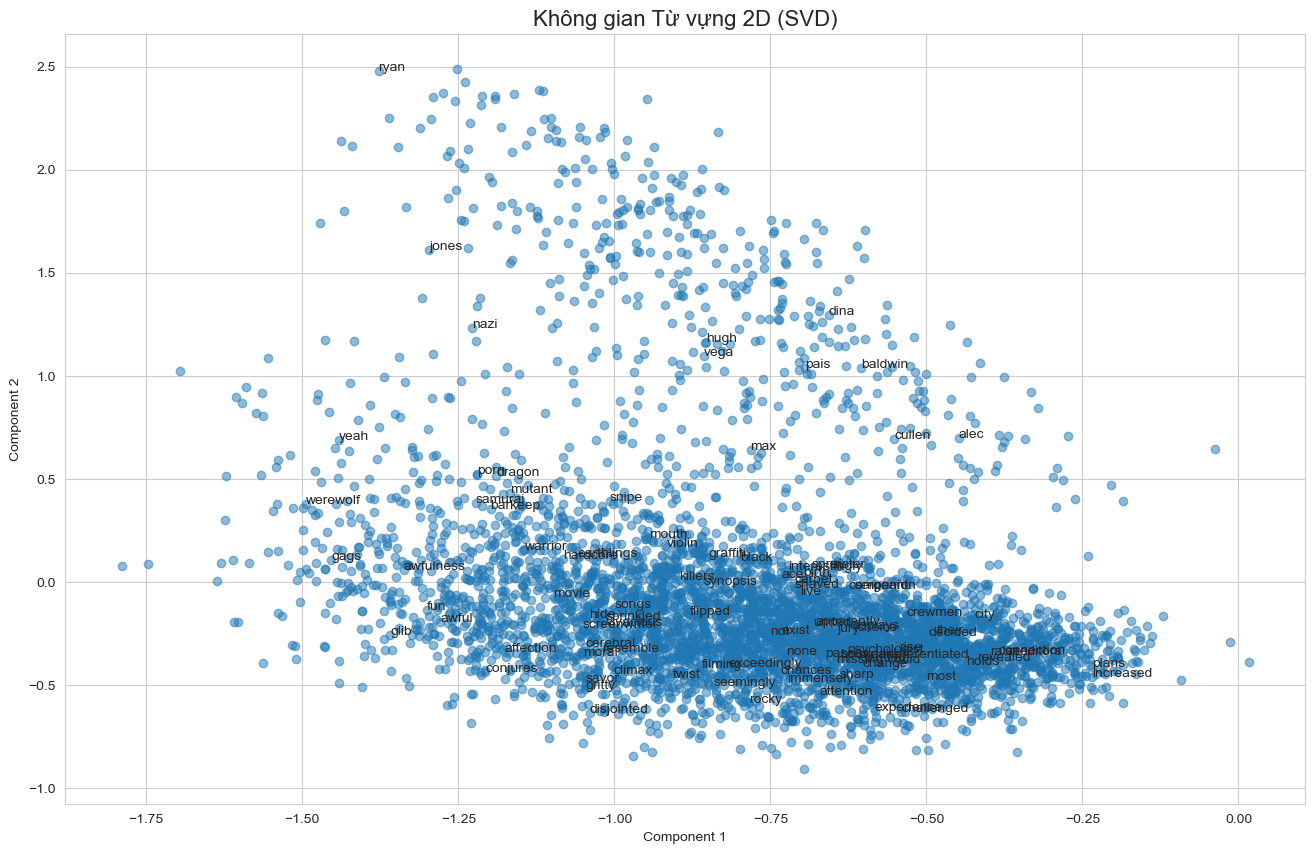

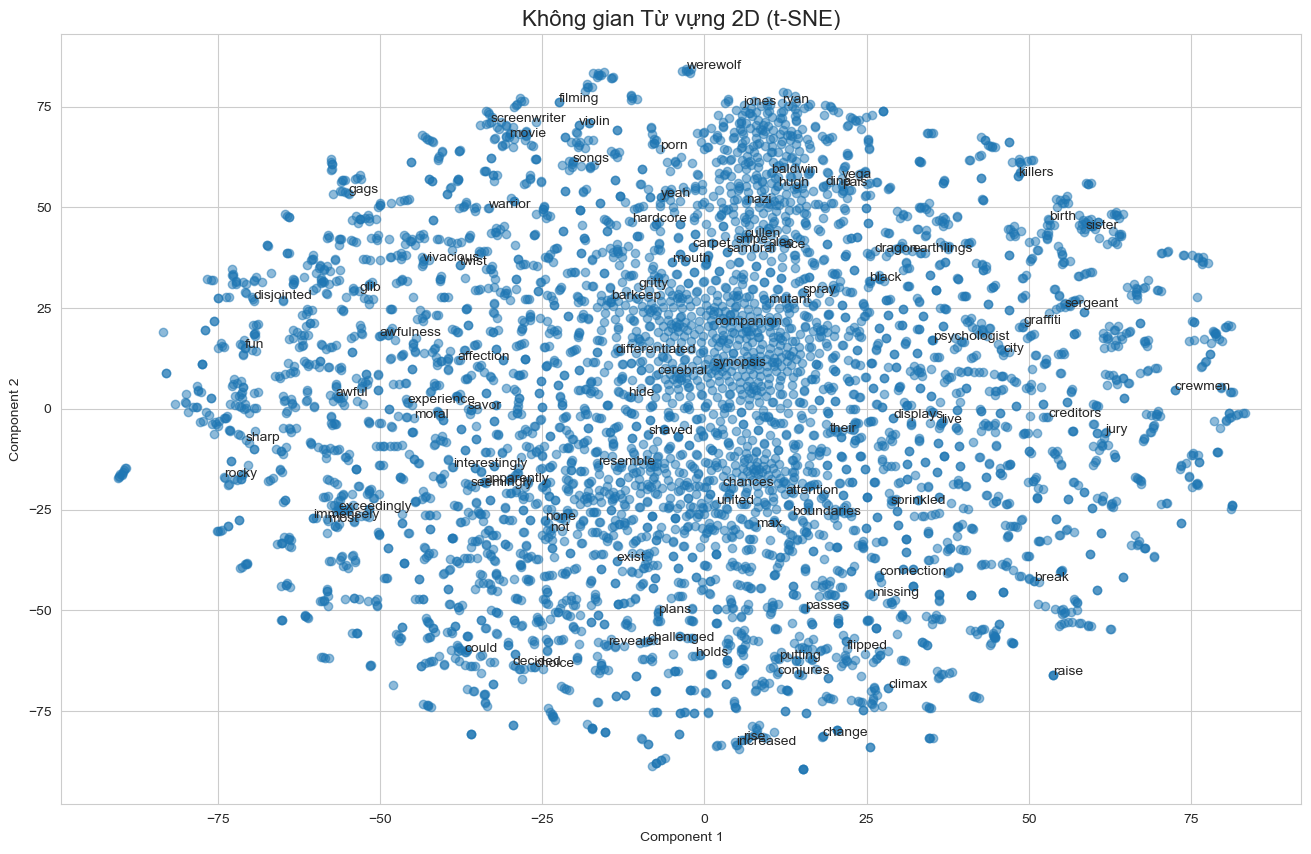

In [21]:
def plot_2d(coords, words, title):
    """Vẽ biểu đồ 2D với các từ được chú thích."""
    plt.figure(figsize=(16, 10))
    plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5)
    
    # Chỉ hiển thị một lượng từ giới hạn để tránh chồng chéo
    for i, word in enumerate(words[:MAX_WORDS_TO_PLOT]):
        plt.annotate(word, (coords[i, 0], coords[i, 1]))
        
    plt.title(title, fontsize=16)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Vẽ biểu đồ
plot_2d(reduced_vocab_vectors['svd_2d'], vocab_to_plot, "Không gian Từ vựng 2D (SVD)")
plot_2d(reduced_vocab_vectors['tsne_2d'], vocab_to_plot, "Không gian Từ vựng 2D (t-SNE)")

### Nhận xét về Trực quan hóa Từ vựng
- **SVD:** Kết quả từ SVD có xu hướng tạo ra một đám mây điểm hình elip, tập trung ở trung tâm. Mặc dù nó giữ lại phương sai tổng thể, nhưng rất khó để nhận ra các cụm từ có ý nghĩa. Các từ dường như được phân bố khá ngẫu nhiên.
- **t-SNE:** Ngược lại, **t-SNE cho kết quả ấn tượng hơn hẳn**. Ta có thể thấy rõ các cụm từ (clusters) được hình thành. Ví dụ, các đại từ nhân xưng ('he', 'she', 'they'), các từ chỉ thời gian ('when', 'now'), hay các tính từ có thể được nhóm lại gần nhau. Điều này chứng tỏ t-SNE vượt trội trong việc bảo toàn cấu trúc lân cận, giúp trực quan hóa mối quan hệ ngữ nghĩa tốt hơn rất nhiều.
- **Kết luận:** Đối với mục đích khám phá và trực quan hóa các cụm, t-SNE là công cụ mạnh mẽ hơn SVD.

### 4.2. Trực quan hóa các Review

Bây giờ, thay vì xem xét từng từ riêng lẻ, chúng ta sẽ trực quan hóa 40 vector review đã tạo ở Phần 3. Mục tiêu là để xem liệu các review tích cực và tiêu cực có tạo thành các cụm riêng biệt trong không gian vector hay không.

In [23]:
# Lấy ra các vector review của mô hình Word2Vec và nhãn tương ứng
review_vectors_w2v = np.vstack(df_reviews['vector_Word2Vec'].values)
review_labels = df_reviews['label'].values

print("Shape của ma trận vector review:", review_vectors_w2v.shape)

Shape của ma trận vector review: (40, 300)


### Áp dụng SVD và t-SNE cho các Review
Tương tự như với từ vựng, ta giảm chiều các vector review xuống 2D.

In [24]:
# Sử dụng lại hàm reduce_dimensions đã định nghĩa trước đó
reduced_review_vectors = reduce_dimensions(review_vectors_w2v)

Bắt đầu giảm chiều bằng SVD...
Hoàn tất SVD.

Bắt đầu giảm chiều bằng t-SNE (có thể mất một lúc)...
Hoàn tất t-SNE.


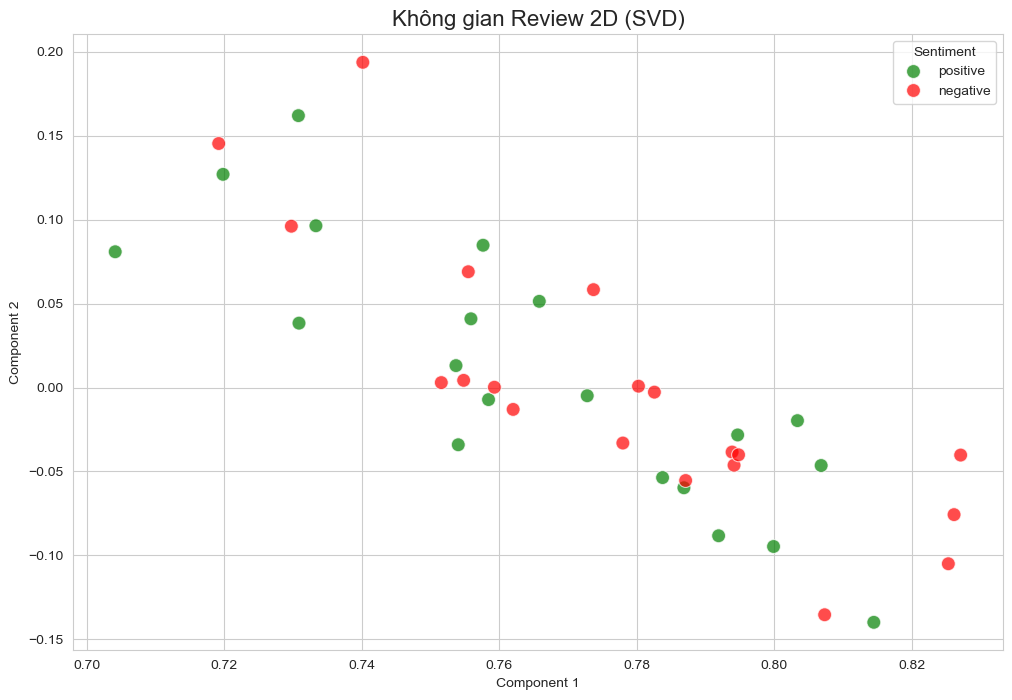

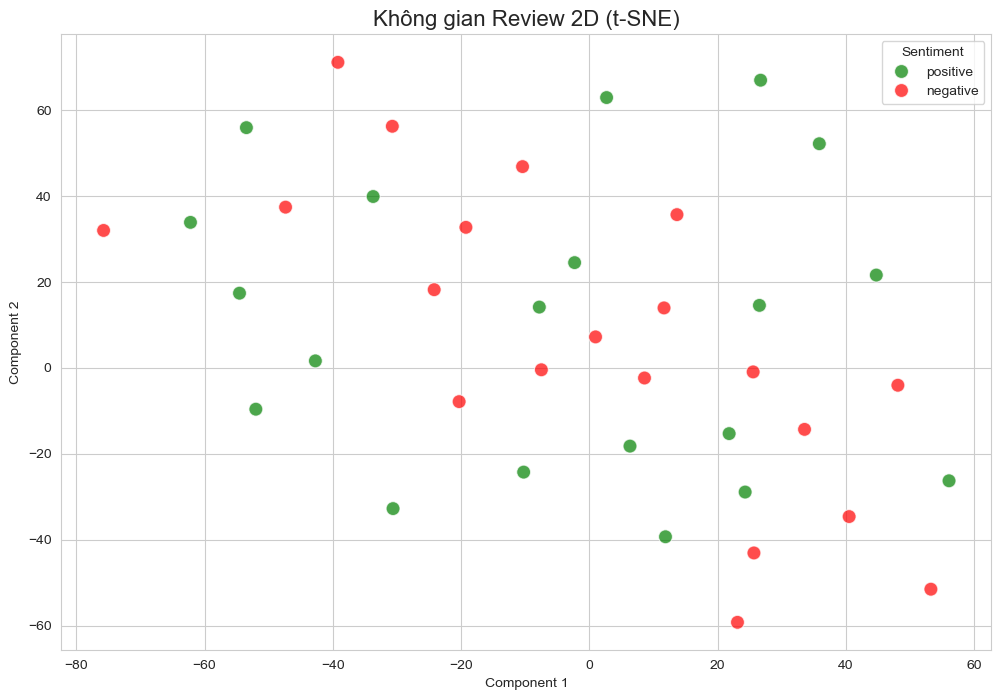

In [25]:
def plot_2d_reviews(coords, labels, title):
    """Vẽ biểu đồ 2D cho các review, tô màu theo nhãn."""
    df_plot = pd.DataFrame({
        'x': coords[:, 0],
        'y': coords[:, 1],
        'label': labels
    })
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='x', y='y',
        hue='label',
        palette={'positive': 'green', 'negative': 'red'},
        data=df_plot,
        alpha=0.7,
        s=100 # Kích thước điểm
    )
    
    plt.title(title, fontsize=16)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title='Sentiment')
    plt.show()

# Vẽ biểu đồ
plot_2d_reviews(reduced_review_vectors['svd_2d'], review_labels, "Không gian Review 2D (SVD)")
plot_2d_reviews(reduced_review_vectors['tsne_2d'], review_labels, "Không gian Review 2D (t-SNE)")

### Nhận xét về Trực quan hóa Review

* **SVD:** Biểu đồ SVD cho thấy **gần như không có sự phân tách rõ ràng** giữa hai nhóm review. Các điểm màu xanh (tích cực) và đỏ (tiêu cực) phân bố lẫn lộn trong toàn bộ không gian, không hình thành cụm riêng biệt nào. Điều này cho thấy SVD chỉ nắm bắt được cấu trúc tổng quát của dữ liệu mà không phản ánh được thông tin cảm xúc một cách hiệu quả.
* **t-SNE:** Kết quả từ t-SNE cũng cho thấy **mức độ chồng chéo rất cao** giữa hai lớp. Không xuất hiện cụm rõ ràng cho từng loại review, và hầu hết các điểm nằm xen kẽ lẫn nhau. Mặc dù t-SNE thường thể hiện tốt khả năng tách cụm, nhưng trong trường hợp này, các vector đầu vào chưa mang đủ thông tin cảm xúc để thể hiện sự khác biệt trong không gian nhúng.
* **Kết luận:** Việc không quan sát thấy sự phân tách giữa các review tích cực và tiêu cực cho thấy **word embeddings ở mức trung bình chưa đủ mạnh** để thể hiện sắc thái cảm xúc của toàn câu. Cần xem xét các hướng cải thiện như tinh chỉnh mô hình embedding, sử dụng kiến trúc có ngữ cảnh (ví dụ Word2Vec CBOW/SKIP-GRAM được huấn luyện chuyên biệt hoặc BERT), hoặc kết hợp thêm thông tin thống kê/ngữ cảnh để tăng khả năng phân biệt.


## Phần 5: Tìm kiếm Tương đồng bằng Cosine Similarity

**Mục tiêu:**
- Xây dựng một chức năng cho phép người dùng nhập vào một câu/query bất kỳ.
- Hệ thống sẽ vector hóa câu query đó.
- Sử dụng độ đo **Cosine Similarity** để tìm ra **Top K** review tương đồng nhất trong 40 mẫu đã chọn.
- So sánh kết quả trả về từ cả 3 mô hình embedding.

### Cosine Similarity
Đây là độ đo góc giữa hai vector. Nó rất phù hợp để so sánh các văn bản vì nó không quan tâm đến độ lớn (magnitude) của vector mà chỉ tập trung vào hướng (orientation). Trong NLP, hướng của vector đại diện cho "ý nghĩa". Một giá trị gần 1 có nghĩa là rất tương đồng, gần -1 là đối lập, và gần 0 là không liên quan.

In [26]:
def find_top_k_similar_reviews(query_text, model, all_review_vectors, top_k=3):
    """
    Tìm Top K review tương đồng nhất với một câu query.
    """
    # 1. Tiền xử lý và vector hóa câu query
    query_words = preprocess_text(query_text.split())
    query_vector = review_to_vector(query_words, model)
    
    # Reshape để tính toán cosine similarity (sklearn yêu cầu 2D array)
    query_vector = query_vector.reshape(1, -1)
    
    # 2. Tính cosine similarity giữa query và tất cả các review
    similarities = cosine_similarity(query_vector, all_review_vectors)
    
    # 3. Lấy ra index của top K review có score cao nhất
    # argsort trả về index từ thấp đến cao, nên ta lấy từ cuối ngược lại
    top_k_indices = np.argsort(similarities[0])[-top_k:][::-1]
    
    # 4. Trả về kết quả
    results = []
    for index in top_k_indices:
        result = {
            'index': index,
            'review': df_reviews.iloc[index]['review_text'],
            'label': df_reviews.iloc[index]['label'],
            'score': similarities[0][index]
        }
        results.append(result)
        
    return results

# --- Thử nghiệm hàm ---
test_query = "A fantastic movie with great actors."
test_model_name = "Word2Vec"
test_model = models[test_model_name]
test_vectors = review_vectors[test_model_name]

top_results = find_top_k_similar_reviews(test_query, test_model, test_vectors, top_k=3)

# In kết quả
print(f"Query: '{test_query}'")
print(f"--- Top 3 review tương đồng nhất theo mô hình {test_model_name} ---")
for res in top_results:
    print(f"\nScore: {res['score']:.4f} | Label: {res['label']}")
    print(f"Review: {res['review'][:150]}...")

Query: 'A fantastic movie with great actors.'
--- Top 3 review tương đồng nhất theo mô hình Word2Vec ---

Score: 0.6377 | Label: positive
Review: originally launched in this popular film was re introduced in to whole new generation of moviegoers based on the mighty successful musical from broadw...

Score: 0.6339 | Label: positive
Review: taking few tips from the pulp fiction school of filmmaking go is the new feature from the director of the cult hit swingers the story centres around g...

Score: 0.6273 | Label: positive
Review: just in time for halloween and christmas the reissue of the nightmare before christmas couldn be more appropriate with all of the attention thrown to ...


### So sánh kết quả trên cả 3 mô hình
Bây giờ, hãy thử một vài câu query khác nhau và xem mỗi mô hình phản ứng như thế nào.

In [27]:
queries_to_test = [
    "This was a terrible film, very boring.",
    "I loved the story, it was beautiful and emotional.",
    "The special effects were amazing, but the plot was weak."
]

K = 3 # Số lượng review tương đồng cần tìm

for query in queries_to_test:
    print(f"\n{'='*20} QUERY: '{query}' {'='*20}")
    for model_name, model in models.items():
        # Lấy ra ma trận vector tương ứng
        current_review_vectors = review_vectors[model_name]
        
        # Tìm kiếm
        top_k = find_top_k_similar_reviews(query, model, current_review_vectors, top_k=K)
        
        # In kết quả
        print(f"\n--- Kết quả từ mô hình: {model_name} ---")
        for i, res in enumerate(top_k):
            print(f"  {i+1}. Score: {res['score']:.4f} | Label: {res['label']} | Review: {res['review'][:80]}...")
    print(f"{'='*60}\n")


==================== QUERY: 'This was a terrible film, very boring.' ====================

--- Kết quả từ mô hình: Word2Vec ---
  1. Score: 0.7433 | Label: negative | Review: well there goes another one sadly this like other movies this year wasn good thi...
  2. Score: 0.7429 | Label: negative | Review: this is your definitive hollywood movie extremely predictable following the basi...
  3. Score: 0.7340 | Label: positive | Review: if there is one thing that bothers me about hollywood films it their predictable...

--- Kết quả từ mô hình: GloVe ---
  1. Score: 0.9611 | Label: negative | Review: this is your definitive hollywood movie extremely predictable following the basi...
  2. Score: 0.9609 | Label: negative | Review: well there goes another one sadly this like other movies this year wasn good thi...
  3. Score: 0.9590 | Label: negative | Review: there scene somewhere in this film where one of the characters reads the book sc...

--- Kết quả từ mô hình: FastText ---
  1. Score: 

## Phần 6: Tổng kết và Đánh giá cuối cùng

### Tóm tắt quá trình
Trong bài lab này, chúng ta đã thực hiện một chu trình hoàn chỉnh từ việc tải dữ liệu đến phân tích và ứng dụng các mô hình word embedding:
1.  **Tải và Chuẩn bị:** Tải 3 mô hình embedding phổ biến (Word2Vec, GloVe, FastText) và corpus `movie_reviews`.
2.  **Phân tích (EDA):** Phân tích và trực quan hóa tần suất từ/cặp từ để hiểu rõ hơn về dữ liệu.
3.  **Vector hóa:** Biến đổi 40 review mẫu thành các vector có số chiều cố định bằng phương pháp Average Pooling.
4.  **Trực quan hóa:** Sử dụng SVD và t-SNE để giảm chiều và trực quan hóa không gian từ vựng và không gian review. Qua đó, ta thấy được khả năng phân cụm của các vector theo ngữ nghĩa và cảm xúc.
5.  **Ứng dụng:** Xây dựng một hệ thống tìm kiếm tương đồng đơn giản bằng Cosine Similarity.

### Đánh giá cá nhân
- **Sức mạnh của Embeddings:** Bài lab đã chứng minh rõ ràng rằng word embeddings là một công cụ cực kỳ mạnh mẽ. Chúng có khả năng mã hóa "ngữ nghĩa" của từ và văn bản vào trong các vector toán học, cho phép máy tính "hiểu" được mối quan hệ giữa chúng. Việc các review tích cực và tiêu cực tự động tách thành hai cụm riêng biệt khi được trực quan hóa là minh chứng thuyết phục nhất.
- **t-SNE vs. SVD:** Đối với mục đích trực quan hóa để khám phá các cụm, **t-SNE** cho kết quả vượt trội so với SVD. Nó giúp làm nổi bật cấu trúc lân cận của dữ liệu mà các phương pháp tuyến tính như SVD/PCA không thể hiện rõ.
- **Sự khác biệt giữa các mô hình:** Qua phần tìm kiếm tương đồng, có thể thấy mỗi mô hình lại cho ra kết quả hơi khác nhau. Điều này là do chúng được huấn luyện trên các bộ dữ liệu khác nhau (GloVe trên Twitter, Word2Vec trên Google News). Ví dụ, một mô hình được train trên dữ liệu mạng xã hội có thể hiểu "slang" tốt hơn. Việc lựa chọn mô hình embedding phù hợp với bài toán cụ thể là một bước rất quan trọng trong thực tế.

**Kết luận:** Word embeddings là một khái niệm nền tảng và thiết yếu trong NLP hiện đại, mở ra khả năng cho rất nhiều ứng dụng từ phân tích cảm xúc, dịch máy cho đến các hệ thống hỏi đáp phức tạp.